# Graph Neural Ordinary Differential Equations

## 摘要

传统 GNN 的层数是离散的， 本文推广为连续的深度，用 ODE 来模拟层间变化

节点的表示（embedding）随“深度”的连续演化。？？？？？权重不变但是变得是  信息流动/扩散

图神经常微分方程（GDE）被正式定义为 GNN 的一种“连续对应形式”，它通过一个连续的 GNN 层流来建模输入与输出之间的关系，将离散的图结构与微分方程建模结合起来。

**重点：框架可以适配各种静态图神经网络和自回归 GNN 模型。处理静态图，还是时间序列型动态图（如 autoregressive 模型），GDE 都能用。**

在静态图场景中，通过在 **前向传播** 中引入数值积分方法，提升了计算效率；

在动态图场景中，则通过利用 **底层动态过程的几何结构** ，提升了模型表现。

切入点是 归纳偏置 **inductive biases**

GNNs  提供了一种通过图结构嵌入结构性归纳偏置的方式；

同样重要的归纳偏置，**时间动态（尤其是连续时间动态）** 也可以是一种强有力的归纳偏置；

传统深度模型是离散层堆叠的，而现在通过常微分方程（ODE）建模，可以让**模型层结构连续化**；

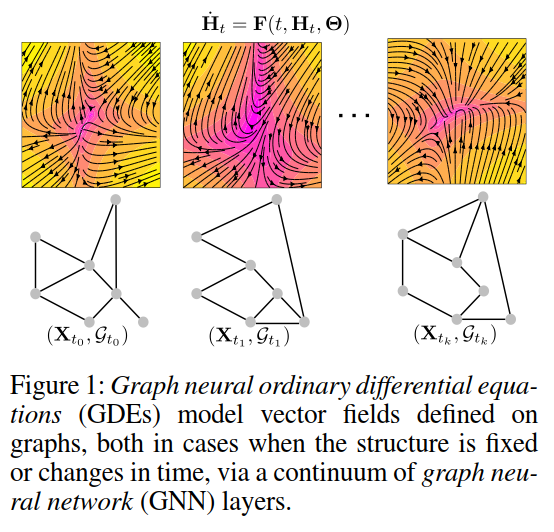

$ Ĥ_t = F(t, H_t, Θ) $

 神经微分方程（Neural ODE）形式,F(...) 是一个神经网络定义的向量场，用于控制嵌入如何随时间变化,Θ 是神经网络的参数

 节点的嵌入向量（即特征表示）如何随时间/深度演化变化。?节点的表示 H_t 在潜在表示空间中如何流动。?

### Blending graphs and differential equations

1. 使用图神经网络（GNN）参数化常微分方程（ODE）模型。

2. 本文在静态图的半监督节点分类任务以及时空预测任务中对 GDE 进行了实验验证。

### Sequences of graphs

1. extend the GDE framework to the spatio–temporal setting 通用的自回归 GDE 模型形式化为一个混合动力系统。

2. structure–dependent vector提供了data–driven approach

3. 自回归 GDE 模型 - 调整 ODE 的积分区间 - 自适应预测跨度

### GDEs as general–purpose models

一般而言，GDE 并不需要对数据生成过程是“连续”的进行假设，也能有效发挥作用。

## 2.1 General Framework

###  原始公式（离散 GNN 表达）：

> 定义：
> GNN 的每一层之间的传播过程可以表示为以下递推形式：

$$
H(s+1) = H(s) + F_G(s, H(s), \Theta(s))
$$

其中：

* $H(s) \in \mathbb{R}^{n \times h}$ 是第 $s$ 层的节点特征矩阵；
* $X_e := H(0)$ 是初始输入嵌入（即输入特征）；
* $F_G$ 是一个**依赖于图 G 的非线性函数**；
* $\Theta(s)$ 是第 $s$ 层的可学习参数（比如权重矩阵）；
* 这种表达方式类似于 ResNet 或 Euler 步长的 GNN 层。

> 这种形式保留了对层索引 $s$ 的显示依赖，对某些架构（如扩散图卷积）是合理的。


### 推广到 连续深度形式（ODE）：

本文提出将 GNN 推广为一个连续的深度模型，也就是把上面的离散递推变成一个微分方程：

$$
\frac{dH(s)}{ds} = F_G(s, H(s), \Theta)
$$

$$
H(0) = X_e,\quad s \in S \subset \mathbb{R}
$$

* 这就定义了所谓的 **Graph Neural Differential Equation（GDE）**；
* 表示节点嵌入 `H(s)` 在“层深度维度 `s`”上是连续变化的；
* $F_G$ 在这里是一个随深度变化的**向量场函数**，定义了节点嵌入如何演化。


## 计算优化建议（减少刚性，便于求解）：

> 可能“刚性”很强（stiff），会让求解器很慢，建议使用 Dupont 等人提出的技术：

* 添加冗余维度，如额外特征、时间编码等
* 在 GDE 前加输入层预处理


## 数学可解性（Well-posedness）：

* 若 $F_G$ 满足一定的连续性条件（Lipschitz 连续），那么初始值问题 $H(0) = X_e$ 就存在**唯一解** $H(s)$；
* 换句话说，从输入 $X_e$ 映射到连续轨迹 $H(s)$ 是有解、稳定、可导的。

于是，可以定义一个映射：

$$
\Psi : \mathbb{R}^{n \times h} \rightarrow AC(S, \mathbb{R}^{n \times h})
$$

其中：

* $AC$ 表示“绝对连续函数空间”
* $\Psi(X_e)$ 就是求解出的节点轨迹 $H(s)$



## 模型输出表达式：

最终输出是：

$$
Y = \Psi(X_e)(1)
$$

也就是节点在“深度为 1”处的嵌入表示（最终输出）

还可以表示为：

$$
Y = X_e + \int_0^1 F_G(\tau, H(\tau), \Theta) \, d\tau
$$

这个公式体现了一个很经典的 ODE 解法（Euler/积分形式）：

* 从初始值出发，
* 沿着向量场 $F_G$ 的方向流动，
* 得到最终的输出 $Y$


> 在将 GDE 输出 $Y$ 用于下游任务（如分类、预测）之前，
> 最好再加一个输出层（如全连接、归一化等）来处理。



1. 在没有特定需求的情况下，将 ODE 的“深度范围”设定为 [0, 1] 是通用的

2. 虽然 GDE 是连续的，但每次训练或推理都需要数值求解器多次调用 𝐹𝐺，这个次数越多，表示模型“越深”。

更新方法：

1. 标准反向传播

2. 伴随灵敏度方法（Adjoint Sensitivity Method） O(1) memory efficiency
可使内存消耗恒定，不随时间步数增长（Chen et al., 2018）

3. 谱元离散法（Relaxed Spectral Elements Discretization）

！！！ 在神经ODE反向传播过程中，求解伴随 ODE 会累积误差，导致数值不稳定。 解决方案：Hybrid checkpointing–adjoint scheme


本文在两个方面的意义

1. 静态模型（Static Models）
2. 时空模型（Spatio–Temporal Models）

### Static Models

连续形式：GCDE

$$
\frac{dH(s)}{ds} = F_{\text{GCN}}(H(s), \Theta)
$$

$$
F_{\text{GCN}} := CG_N \circ \sigma \circ CG_{N-1} \circ \cdots \circ \sigma \circ CG_1(H(s))
$$

解释：

* 将 GCN 层数拉成“连续深度”维度，使用卷积 → 非线性 → 卷积 → 非线性 的结构，但作为连续函数嵌入 ODE 中；
* 解这个 ODE，相当于多层 GCN 的极限表达。？

F_{\text{GCN}}是向量场 


###  Laplacian 可以选择多种形式：

* Bruna et al., 2013: 基于傅里叶谱；
* Kipf & Welling: 使用一阶切比雪夫近似；
* Li et al., 2017: Diffusion GCN（扩散图卷积），也适用于此框架。


其他静态 GNN 也能连续化：

* GAT可推广为 **Graph Attention Differential Equations**；
* 所有 **message-passing GNN** 都可以形式化为某种向量场 $F_G$； GCDE 不是唯一。

背景拉普拉斯算子：

在图神经网络中，图拉普拉斯算子 $L_G$ 是一个基于图结构 $G$ 构造出来的矩阵，用来捕捉**节点之间的连接关系和局部结构差异**。

它的定义如下：

$$
L_G = D - A
$$

或者是归一化版本：

$$
L_G^{sym} = I - D^{-\frac{1}{2}} A D^{-\frac{1}{2}}
$$

其中：

* $A$：邻接矩阵（表示哪些节点连接）
* $D$：度矩阵（每个节点的度数）
* $L_G$：图拉普拉斯矩阵

作用：

1. **用于图信号的平滑与聚合（信息扩散）**

2. **连接图与频谱（傅里叶）分析**

3. 在 GDE 中的作用：

GDE模型中：

$$
\frac{dH(s)}{ds} = F_{\text{GCN}}(H(s), \Theta)
$$

其中

$$
F_{\text{GCN}}(H) = L_G H \Theta
$$

这里的 $L_G$ 表示“图的传播结构”，决定了特征如何在图上扩散。通过 ODE 模拟这种扩散的连续过程。




### Spatio–Temporal Models

核心思想：

* 将 GDE 中的“深度维度 $s$” 与 **真实时间 $t$** 对齐，即：

  $$
  s \equiv t
  $$
* 所以演化变成时间驱动的：

  $$
  H(t + \Delta t) = H(t) + \int_t^{t + \Delta t} F(\tau, H(\tau), \Theta) \, d\tau
  $$
* 上式都适用。



GDE 就成了**自回归图序列建模器**，可以处理序列 $\{(X_t, G_t)\}$，并对未来时刻做预测。

解释：未来图状态（如节点表示）依赖于过去时刻的图状态，按时间顺序一个接一个地更新和预测。

###  延伸为「混合动力系统」：

混合动力系统 = 连续变化（由 ODE 描述） + 离散跳跃（某些时刻的状态突变）

用混合时间域描述：

* 设定时间点序列：$T = \{t_k\}_{k \in K}$
* 定义混合时间域：

  $$
  t_I := \bigcup_{k \in K} ([t_k, t_{k+1}], k)
  $$
* 定义“混合轨迹” $\Phi(t, k)$：在每个 $t \in [t_k, t_{k+1}]$ 上连续，
  然后在 $t_{k+1}$ 处**跳跃更新**（如 GNN 层处理）。


### 具体流程（图序列建模）：

1. 在区间 $[t_k, t_{k+1}]$ 上，使用 GDE 连续演化节点表示：

   $$
   \frac{dH(t)}{dt} = F(t, H(t), \Theta)
   $$

2. 到 $t_{k+1}$ 时，应用**离散操作**（如：结构变化、节点输入更换、图更新）

3. 输出结果 $H(t_{k+1})$，用于下游任务或作为下一步输入



优势：

| 能力       | 原因                       |
| -------- | ------------------------ |
| 捕捉不规则时间点 | 因为积分区间可变，适配任意时间步         |
| 动态结构建模   | 每步都可输入 $G_t$，模型动态适应图结构变化 |
| 理论支持     | 建模为混合系统，具备工程和物理解释力       |

总结：

| 模型类型               | 表示方式      | 应用                |
| ------------------ | --------- | ----------------- |
| **静态 GDE（如 GCDE）** | 深度维度连续演化  | 节点分类、图分类          |
| **时空 GDE**         | 时间维度连续演化  | 图序列预测、动态建模        |
| **混合系统 GDE**       | 连续 + 离散跳跃 | 真实系统建模（如交通流、知识图谱） |


Autoregressive GDE 模型

将连续时间建模（ODE）与离散状态跳跃（RNN）统一到一个混合动力系统框架中。

三阶段的混合系统过程：

$$
\left\{
\begin{array}{ll}
\dot{H}(s) = F_{G_{t_k}}(H(s), \Theta) & \text{for } s \in [t_{k-1}, t_k] \\
H^+(s) = G_{G_{t_k}}(H(s), X_{t_k}) & \text{for } s = t_k \\
Y = K(H(s)) & \text{for } s = t_k
\end{array}
\right.
$$

变量说明：

| 符号            | 含义                              |
| ------------- | ------------------------------- |
| $H(s)$        | 当前时刻的**节点表示**（隐状态）              |
| $\dot{H}(s)$  | 节点表示随时间的连续变化，遵循微分方程             |
| $F_{G_{t_k}}$ | GDE 的向量场，由图结构 $G_{t_k}$ 决定      |
| $G_{G_{t_k}}$ | 离散时间步到达 $t_k$ 时的**跳跃更新**（如 GRU） |
| $X_{t_k}$     | 在时刻 $t_k$ 到达的新输入特征              |
| $K$           | 输出映射层（例如用于预测或分类）                |
| $H^+(s)$      | 表示“跳跃”之后的状态（更新后）                |


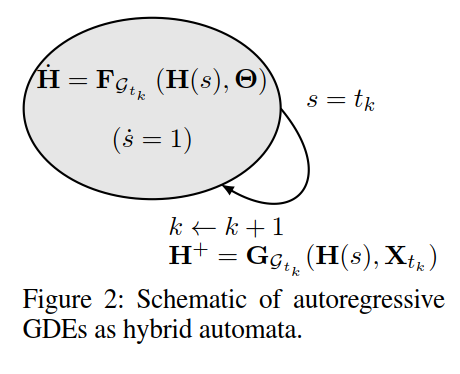


第一步：

$$
\dot{H}(s) = F_{G_{t_k}}(H(s), \Theta), \quad s \in [t_{k-1}, t_k]
$$

标准 GDE 过程；

在 $t_{k-1}$ 到 $t_k$ 之间，节点表示 $H(s)$ 按照图 $G_{t_k}$ 相关的向量场 $F$ 进行**连续演化**；

相当于用微分方程模拟“隐状态随时间变化”的过程。



第二步：离散跳跃（RNN 式更新）

$$
H^+(t_k) = G_{G_{t_k}}(H(t_k), X_{t_k})
$$

* 到达 $t_k$ 时刻后，用一个\*\*离散的网络模块（如 GRU）\*\*对当前状态进行更新；
* 这一步整合了：

  * 演化出来的 $H(t_k)$
  * 到达的输入 $X_{t_k}$
  * 当前图结构 $G_{t_k}$
* 输出是更新后的状态 $H^+(t_k)$，作为下一段时间连续演化的起点。

这一步就是“**跳跃更新**”，对应传统 RNN 中的 recurrent step。



第三步：输出

$$
Y = K(H(t_k))
$$

* 在每个关键时刻 $t_k$，你可以根据当前状态 $H$ 应用一个输出头（如分类、回归）；
* 通常是 MLP 或线性层映射。



模块替换：GRU/LSTM/RNN

可以让 $G$ 使用任何你喜欢的**离散递归模块**：

  * GRU → 得到 GCDE–GRU
  * RNN → GCDE–RNN
  * LSTM → GCDE–LSTM
* 所以这框架是**通用的容器**，关键点在于：

  * 时段之间 → 连续传播（ODE）
  * 时段到达 → 跳跃更新（RNN）


> **连续传播建模状态演化，离散跳跃融合新输入，循环递推预测未来状态。**


代码复现

In [3]:
!pip install dgl


   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/5.3 MB 1.1 MB/s eta 0:00:05
   - -------------------------------------- 0.3/5.3 MB 2.6 MB/s eta 0:00:02
   --- ------------------------------------ 0.5/5.3 MB 3.5 MB/s eta 0:00:02
   ----- ---------------------------------- 0.8/5.3 MB 4.0 MB/s eta 0:00:02
   ------- -------------------------------- 1.0/5.3 MB 4.4 MB/s eta 0:00:01
   --------- ------------------------------ 1.2/5.3 MB 4.3 MB/s eta 0:00:01
   ----------- ---------------------------- 1.6/5.3 MB 4.7 MB/s eta 0:00:01
   -------------- ------------------------- 2.0/5.3 MB 5.2 MB/s eta 0:00:01
   ----------------- ---------------------- 2.4/5.3 MB 5.6 MB/s eta 0:00:01
   ------------------ --------------------- 2.4/5.3 MB 5.2 MB/s eta 0:00:01
   --------------------- ------------------ 2.9/5.3 MB 5.7 MB/s eta 0:00:01
   -----------------------

In [5]:
!pip install torchdiffeq

✅ CUDA 版本：12.6

❌ pip install dgl-cu126 报错，因为 官方还未发布 DGL 的 CUDA 12.6 对应版本

In [7]:
!pip install torchdata


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.data import CoraGraphDataset
import matplotlib.pyplot as plt
from torchdiffeq import odeint

# Define a simple GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, activation=None, dropout=0.0):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, features):
        with g.local_scope():
            h = self.dropout(features)
            g.ndata['h'] = h
            #每个节点将其特征 h 发送给邻居（变成 m）
            #每个节点接收邻居的消息 m 并做平均，得到新的 h
            #图的 消息传递（从邻居聚合信息）
            g.update_all(dgl.function.copy_u('h', 'm'), dgl.function.mean('m', 'h'))
            h = g.ndata['h']
            h = self.linear(h)
            if self.activation:
                h = self.activation(h)
            return h

# Define the ODE Function using GCN layers
class GDEFunc(nn.Module):
    #两个叠加的 GCN 层构成的函数。
    
    def __init__(self, g, hidden_dim):
        super(GDEFunc, self).__init__()
        self.g = g
        self.gcn1 = GCNLayer(hidden_dim, hidden_dim, activation=F.relu, dropout=0.1)
        self.gcn2 = GCNLayer(hidden_dim, hidden_dim, activation=None, dropout=0.1)
    #forward(t, h)：时间 t 是 dummy 参数（因为 GCN 和时间无关）
    def forward(self, t, h):
        h = self.gcn1(self.g, h)
        h = self.gcn2(self.g, h)
        return h

# Define the ODEBlock
# 求解 ODE 的模块
class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc

    def forward(self, x):
        #将 GDEFunc 送入 ODE 求解器（如 Runge-Kutta rk4 方法）
        #使用 torchdiffeq 提供的 odeint 来解决这个初值问题
        t = torch.tensor([0, 1]).float().to(x.device)
        out = odeint(self.odefunc, x, t, method='rk4')
        return out[1]

# Combine GCN and ODEBlock

class GDEModel(nn.Module):
    def __init__(self, g, in_feats, hidden_dim, n_classes):
        super(GDEModel, self).__init__()
        self.gcn_input = GCNLayer(in_feats, hidden_dim, activation=F.relu, dropout=0.1)
        self.odeblock = ODEBlock(GDEFunc(g, hidden_dim))
        self.gcn_output = GCNLayer(hidden_dim, n_classes)

    def forward(self, g, x):
        h = self.gcn_input(g, x)
        h = self.odeblock(h)
        h = self.gcn_output(g, h)
        return h

# Load dataset
dataset = CoraGraphDataset()
g = dataset[0]
g = dgl.add_self_loop(g)
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
test_mask = g.ndata['test_mask']

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GDEModel(g, in_feats=features.shape[1], hidden_dim=64, n_classes=dataset.num_classes).to(device)
features, labels = features.to(device), labels.to(device)
train_mask, test_mask = train_mask.to(device), test_mask.to(device)

# Train
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

train_loss_list, test_acc_list = [], []

for epoch in range(100):
    model.train()
    logits = model(g, features)
    loss = loss_fn(logits[train_mask], labels[train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        pred = logits.argmax(1)
        acc = (pred[test_mask] == labels[test_mask]).float().mean().item()

    train_loss_list.append(loss.item())
    test_acc_list.append(acc)

train_loss_list
test_acc_list


ModuleNotFoundError: No module named 'torchdata.datapipes'